---
title: 01 - Load and integrate SMART-seq2 sequencing of human blastocysts
author: Naz Salehin, Martin Proks
date: 21-10-2024
model: v1.1
---

## Load in libraries 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scvi
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import anndata as ad

In [2]:
import sys; sys.path.append("../scripts/")
from helpers import normalize_smartseq
GENE_LEN = '/home/gkb340/Brickman/shared/references/homo_sapiens/ensembl/GRCh38_110/Homo_sapiens.GRCh38.110.gene_length.tsv'
REMAKE_FIGURES = False

## Load in data

### Initial sequencing from the Crick

In [1]:
crick_adata = sc.read_h5ad("../data/external/niakan_et_al/niakan_combined_matrix.h5ad")

NameError: name 'sc' is not defined

In [15]:
crick_adata.obs['sample_fine'] = crick_adata.obs['sample'].str.split('_', expand=True)[0].to_list()
Simon_metadata = pd.read_table("../data/processed/Samples_LIMSID.csv" ,sep = ',')
crick_adata.obs = crick_adata.obs.join(Simon_metadata[['LIMS.ID','Embryo']].set_index('LIMS.ID'), on='sample_fine')

In [16]:
crick_adata.obs_names = crick_adata.obs['Embryo'] + '_' + crick_adata.obs['sample']

crick_adata.obs['treatment'] = 'DMSO'
crick_adata.obs.loc[crick_adata.obs_names.str.contains('Ulix'), 'treatment'] = 'Ulix'

crick_adata.obs['batch'] = "NIAKAN_1"
crick_adata.obs['experiment'] = "Simon et al, 2024"
crick_adata.obs['technology'] = "SMART-seq2"
crick_adata

AnnData object with n_obs × n_vars = 132 × 62754
    obs: 'sample', 'fastq_1', 'fastq_2', 'sample_fine', 'Embryo', 'treatment', 'batch', 'experiment', 'technology'
    var: 'gene_symbol'

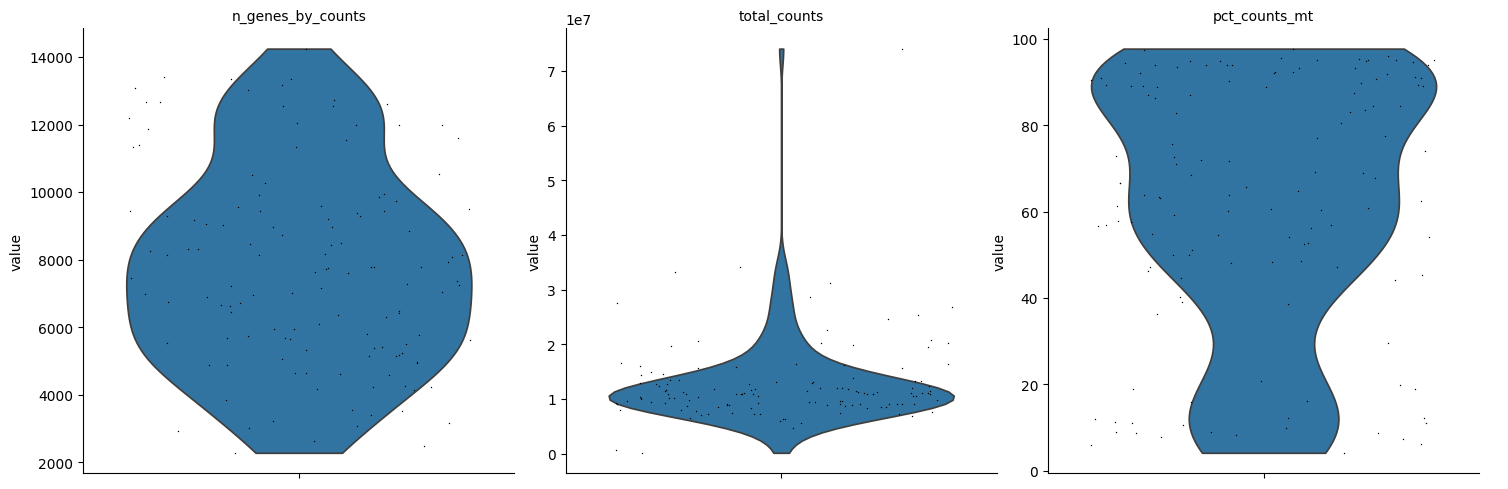

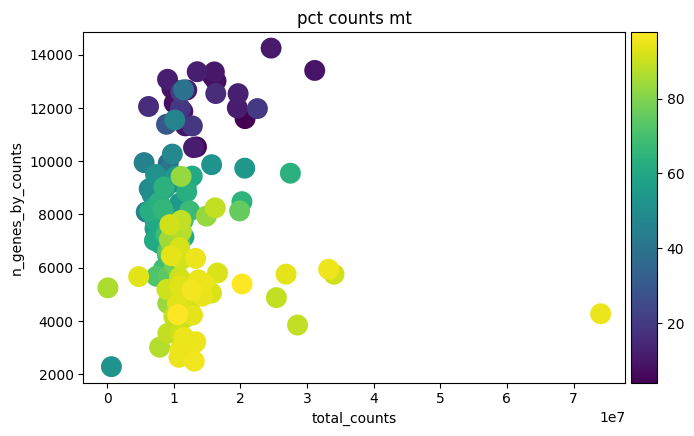

<Axes: xlabel='pct_counts_mt', ylabel='Count'>

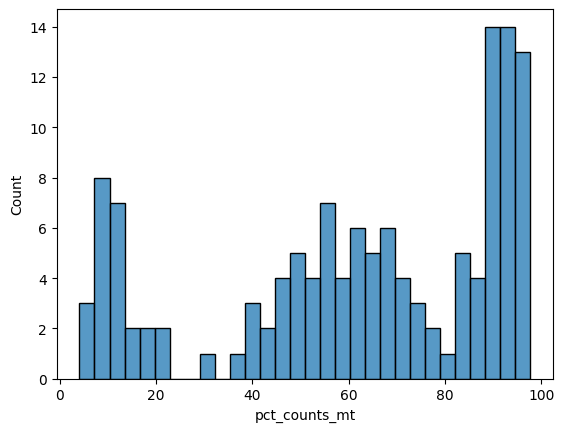

In [20]:
crick_adata.var["mt"] = crick_adata.var.gene_symbol.str.startswith("MT-")
sc.pp.calculate_qc_metrics(crick_adata, qc_vars=["mt"], inplace=True, log1p=True)
sc.pl.violin(crick_adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True)
sc.pl.scatter(crick_adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
sns.histplot(x=crick_adata.obs['pct_counts_mt'], bins=30)

In [21]:
crick_adata = crick_adata[crick_adata.obs.pct_counts_mt < 30].copy()
crick_adata = crick_adata[crick_adata.obs.n_genes_by_counts > 8000].copy()

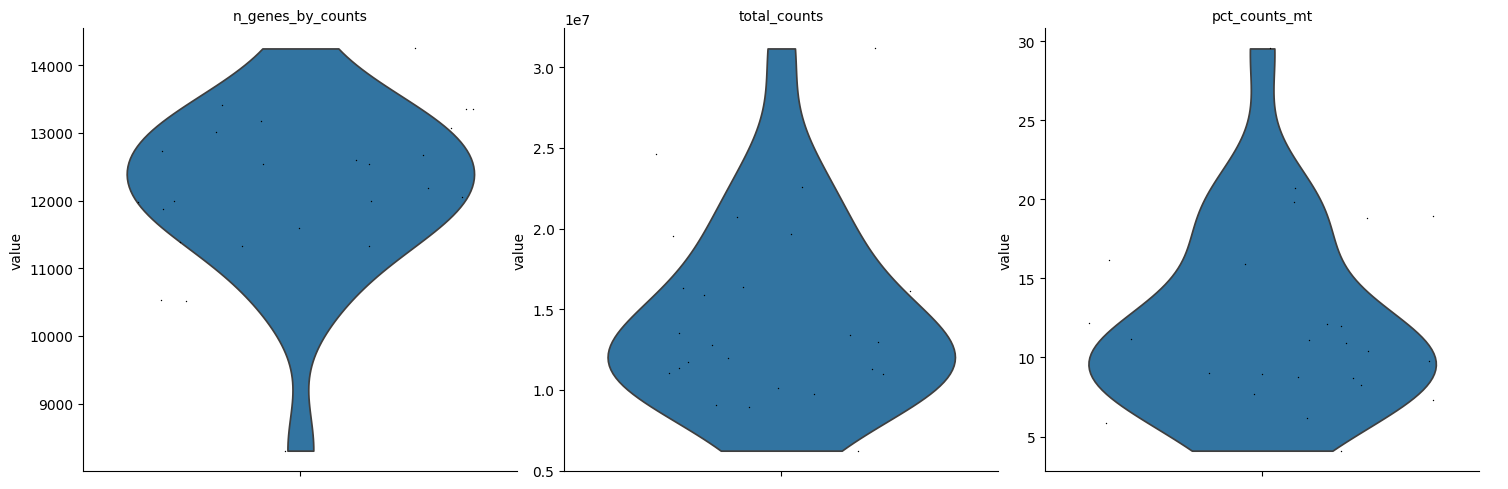

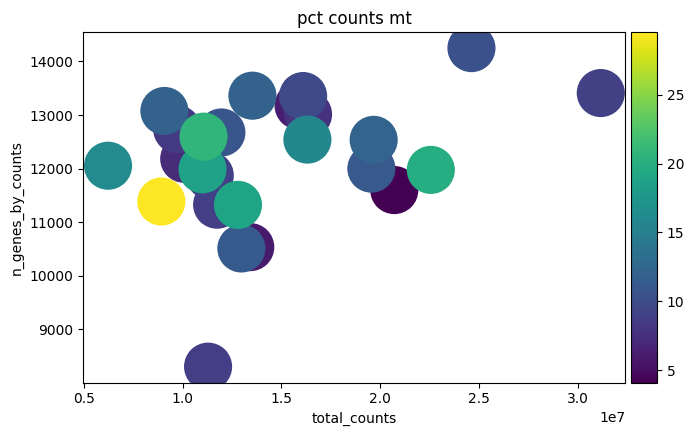

<Axes: xlabel='pct_counts_mt', ylabel='Count'>

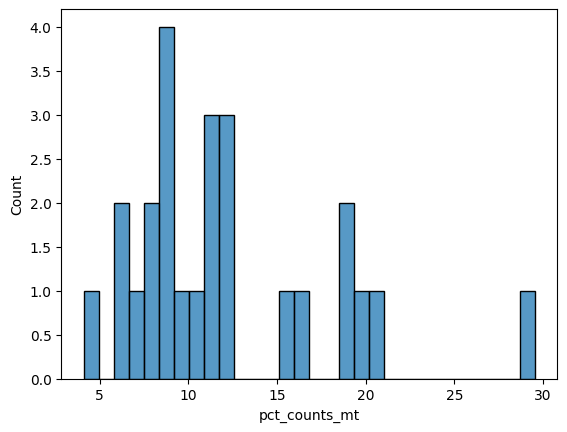

In [22]:
sc.pl.violin(crick_adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True)
sc.pl.scatter(crick_adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
sns.histplot(x=crick_adata.obs['pct_counts_mt'], bins=30)

### Sequencing from Cambridge

In [17]:
babraham_adata = sc.read_h5ad("../data/assays/SCR_NS_20240521/processed/GRCh38_110/combined_matrix.merged.h5ad")


In [18]:
babraham_adata.obs_names = babraham_adata.obs['sample']

babraham_adata.obs['treatment'] = 'DMSO'
babraham_adata.obs.loc[babraham_adata.obs_names.str.contains('Ulix'), 'treatment'] = 'Ulix'

babraham_adata.obs['batch'] = "NIAKAN_2"
babraham_adata.obs['experiment'] = "Simon et al, 2024"
babraham_adata.obs['technology'] = "SMART-seq2"
babraham_adata

AnnData object with n_obs × n_vars = 100 × 62754
    obs: 'sample', 'fastq_1', 'fastq_2', 'treatment', 'batch', 'experiment', 'technology'
    var: 'gene_symbol'

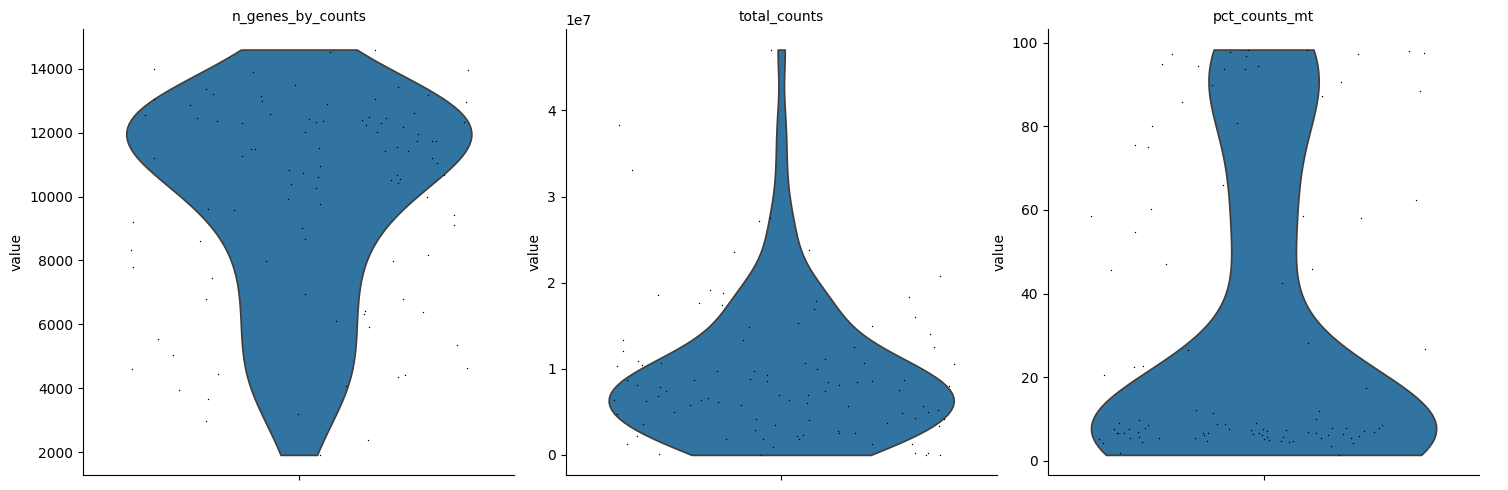

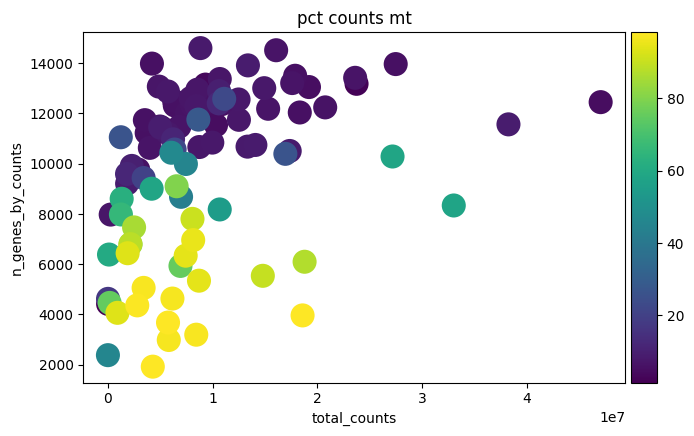

<Axes: xlabel='pct_counts_mt', ylabel='Count'>

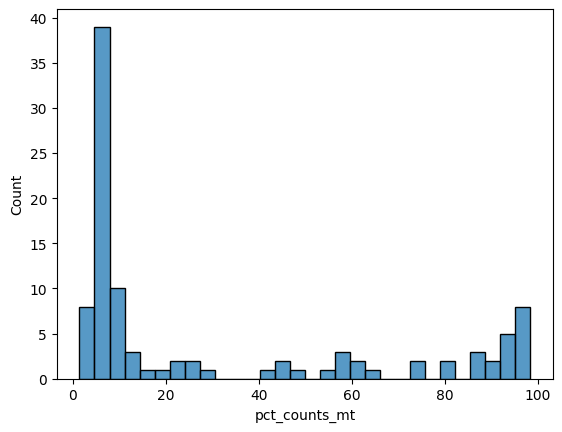

In [23]:
babraham_adata.var["mt"] = babraham_adata.var.gene_symbol.str.startswith("MT-")
sc.pp.calculate_qc_metrics(babraham_adata, qc_vars=["mt"], inplace=True, log1p=True)
sc.pl.violin(babraham_adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True)
sc.pl.scatter(babraham_adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
sns.histplot(x=babraham_adata.obs['pct_counts_mt'], bins=30)

In [24]:
babraham_adata = babraham_adata[babraham_adata.obs.pct_counts_mt < 30].copy()
babraham_adata = babraham_adata[babraham_adata.obs.n_genes_by_counts > 8000].copy()

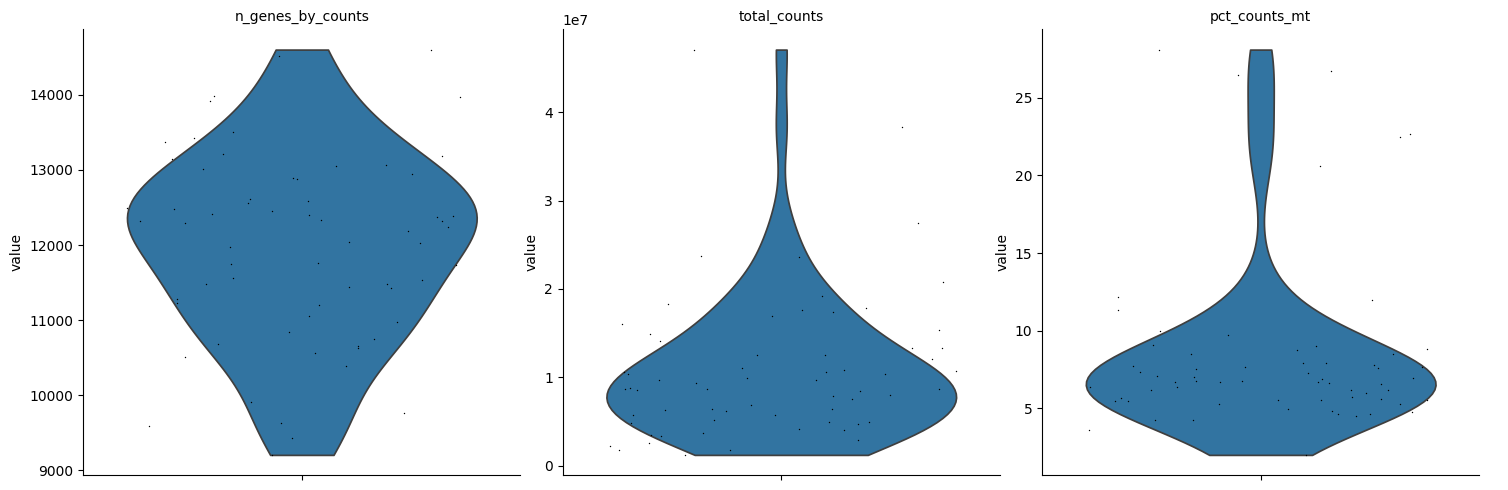

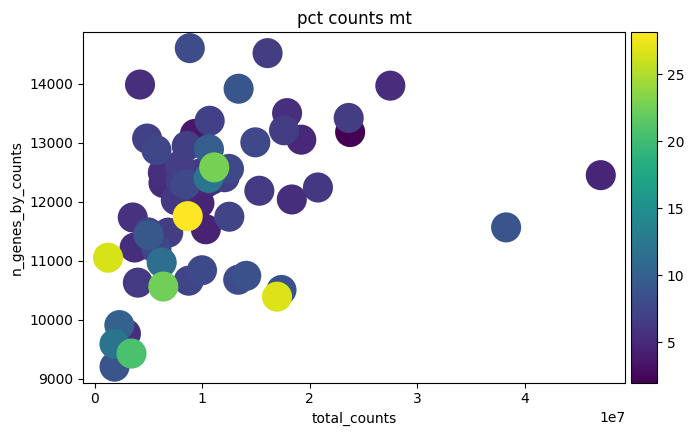

<Axes: xlabel='pct_counts_mt', ylabel='Count'>

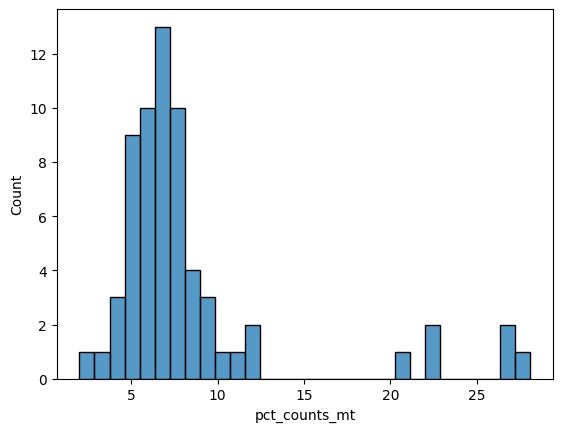

In [25]:
sc.pl.violin(babraham_adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True)
sc.pl.scatter(babraham_adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
sns.histplot(x=babraham_adata.obs['pct_counts_mt'], bins=30)

### Concatenate anndata

In [26]:
adata = ad.concat([crick_adata, babraham_adata])

In [27]:
adata.obs

,sample,fastq_1,fastq_2,treatment,batch,experiment,technology,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt
Human_Ulix_5_SIM5110A133,SIM5110A133,/scratch/Brickman/pipelines/Niakan2024_human/r...,/scratch/Brickman/pipelines/Niakan2024_human/r...,Ulix,NIAKAN_1,"Simon et al, 2024",SMART-seq2,12540,9.436759,16318175.0,16.607790,27.067255,33.021707,40.767923,53.448765,2596380.0,14.769629,15.910971
Human_Ulix_4_SIM5110A88,SIM5110A88,/scratch/Brickman/pipelines/Niakan2024_human/r...,/scratch/Brickman/pipelines/Niakan2024_human/r...,Ulix,NIAKAN_1,"Simon et al, 2024",SMART-seq2,13011,9.473627,16349510.0,16.609709,23.037987,29.586251,37.693747,51.772891,1259369.0,14.046123,7.702793
Human_Ulix_5_SIM5110A127,SIM5110A127,/scratch/Brickman/pipelines/Niakan2024_human/r...,/scratch/Brickman/pipelines/Niakan2024_human/r...,Ulix,NIAKAN_1,"Simon et al, 2024",SMART-seq2,12053,9.397152,6229982.0,15.644884,27.717287,34.285813,42.493606,56.090708,1005475.0,13.820971,16.139294
Human_Ulix_4_SIM5110A85,SIM5110A85,/scratch/Brickman/pipelines/Niakan2024_human/r...,/scratch/Brickman/pipelines/Niakan2024_human/r...,Ulix,NIAKAN_1,"Simon et al, 2024",SMART-seq2,14246,9.564302,24619864.0,17.019064,19.988749,25.531935,33.104822,46.332910,2569475.0,14.759212,10.436593
Human_Ulix_5_SIM5110A142,SIM5110A142,/scratch/Brickman/pipelines/Niakan2024_human/r...,/scratch/Brickman/pipelines/Niakan2024_human/r...,Ulix,NIAKAN_1,"Simon et al, 2024",SMART-seq2,10535,9.262553,13425119.0,16.412638,23.108585,31.311454,41.168916,56.296395,788035.0,13.577299,5.869855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Human_Ulix_7_1,Human_Ulix_7_1,/maps/projects/dan1/data/Brickman/assays/SCR_N...,/maps/projects/dan1/data/Brickman/assays/SCR_N...,Ulix,NIAKAN_2,"Simon et al, 2024",SMART-seq2,12338,9.420520,7991007.0,15.893827,20.325098,26.809174,35.067495,49.236786,538162.0,13.195917,6.734595
Human_DMSO_6_18,Human_DMSO_6_18,/maps/projects/dan1/data/Brickman/assays/SCR_N...,/maps/projects/dan1/data/Brickman/assays/SCR_N...,DMSO,NIAKAN_2,"Simon et al, 2024",SMART-seq2,9591,9.168685,1832853.0,14.421385,23.418299,29.630854,37.395907,51.251028,220061.0,12.301664,12.006473
Human_Ulix_6_6,Human_Ulix_6_6,/maps/projects/dan1/data/Brickman/assays/SCR_N...,/maps/projects/dan1/data/Brickman/assays/SCR_N...,Ulix,NIAKAN_2,"Simon et al, 2024",SMART-seq2,11746,9.371353,12517080.0,16.342606,20.012575,26.891527,35.473273,50.137876,913879.0,13.725454,7.301055
Human_Ulix_6_30,Human_Ulix_6_30,/maps/projects/dan1/data/Brickman/assays/SCR_N...,/maps/projects/dan1/data/Brickman/assays/SCR_N...,Ulix,NIAKAN_2,"Simon et al, 2024",SMART-seq2,13966,9.544453,27490648.0,17.129356,18.133076,24.556694,33.008141,47.091940,1456117.0,14.191284,5.296772


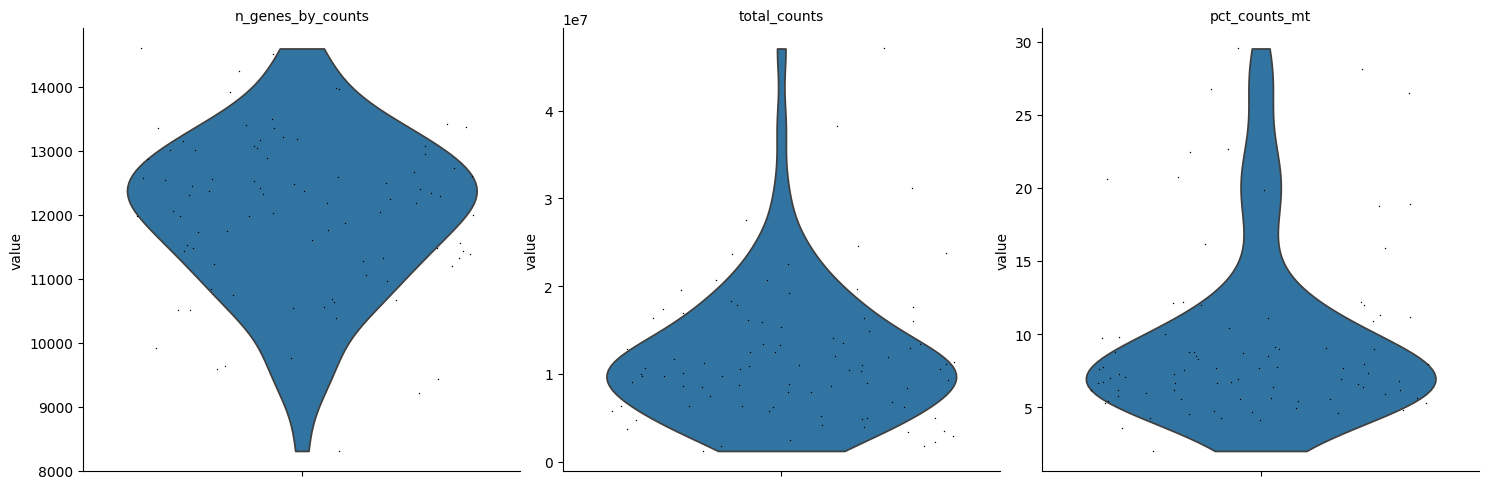

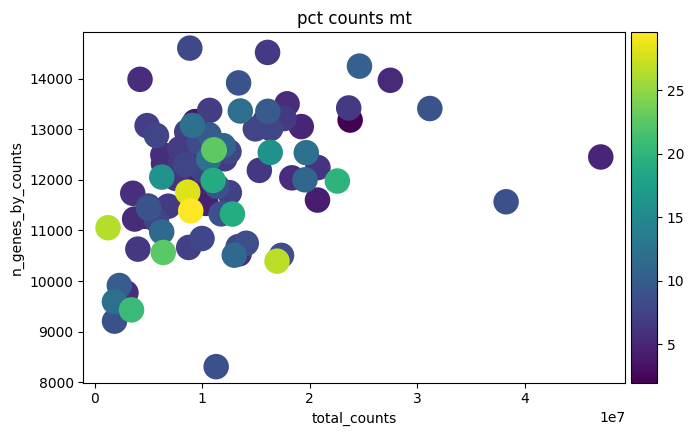

<Axes: xlabel='pct_counts_mt', ylabel='Count'>

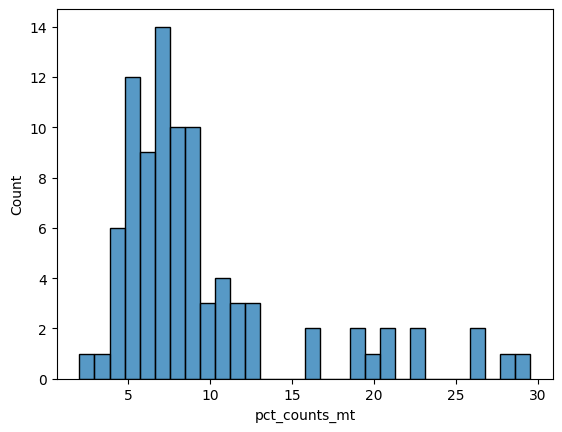

In [28]:
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
sns.histplot(x=adata.obs['pct_counts_mt'], bins=30)

In [29]:
adata = normalize_smartseq(adata, GENE_LEN)
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.raw = adata

SMART-SEQ: Normalization
SMART-SEQ: Common genes 62663


In [30]:
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3_000)

/projects/dan1/data/Brickman/conda/envs/scvi-1.1.5/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [31]:
sc.tl.pca(adata)

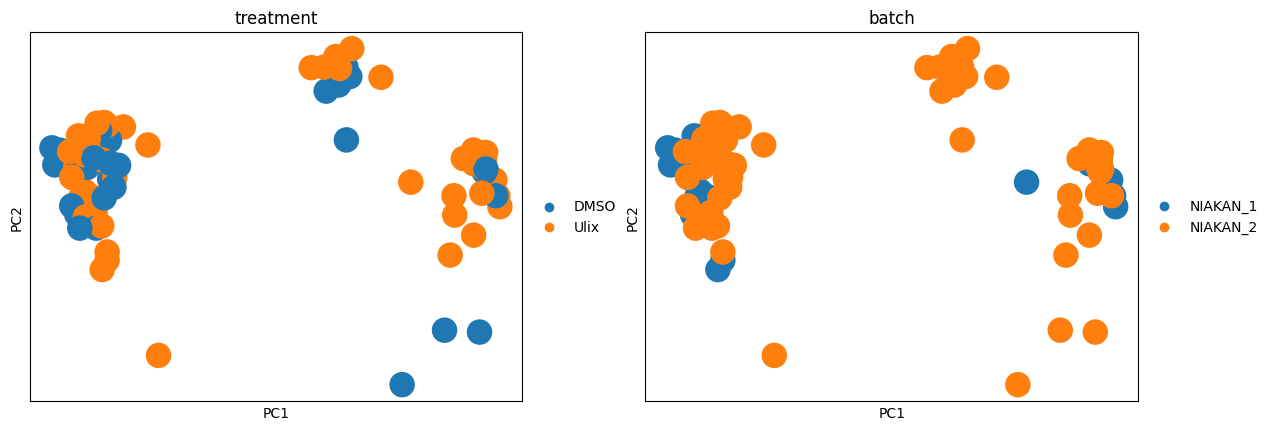

In [33]:
sc.pl.pca(adata, color=['treatment', 'batch'])

In [34]:
del adata.varm['PCs']

In [35]:
adata.write("../results/niakan_08.adata.h5ad")

## Model predictions

In [36]:
lvae = scvi.model.SCANVI.load('/home/gkb340/Brickman/projects/proks-salehin-et-al-v2/results/100_human_integration/scanvi_ns_15/')
scvi.model.SCANVI.prepare_query_anndata(adata, lvae)
lvae_q = scvi.model.SCANVI.load_query_data(adata, lvae)

INFO     File                                                                                                      
         /home/gkb340/Brickman/projects/proks-salehin-et-al-v2/results/100_human_integration/scanvi_ns_15/model.pt 
         already downloaded                                                                                        


/projects/dan1/data/Brickman/conda/envs/scvi-1.1.5/lib/python3.10/site-packages/scvi/model/base/_utils.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.loa

INFO     Found 100.0% reference vars in query data.                                                                


/projects/dan1/data/Brickman/conda/envs/scvi-1.1.5/lib/python3.10/site-packages/scvi/data/_manager.py:215: UserWarning: Missing labels key ct. Filling in with unlabeled category Unknown.
  field_registry[_constants._STATE_REGISTRY_KEY] = field.transfer_field(


In [37]:
lvae_q.train(max_epochs=20, plan_kwargs=dict(weight_decay=0.0), check_val_every_n_epoch=10, early_stopping=True)

INFO     Training for 20 epochs.                                                                                   


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
SLURM auto-requeueing enabled. Setting signal handlers.
/projects/dan1/data/Brickman/conda/envs/scvi-1.1.5/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/projects/dan1/data/Brickman/conda/envs/scvi-1.1.5/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/projects/dan1/data/Brickman/conda/envs/scvi-1.1.5/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 

Epoch 20/20: 100%|██████████| 20/20 [00:01<00:00, 11.64it/s, v_num=1, train_loss_step=5.64e+3, train_loss_epoch=5.64e+3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [00:01<00:00, 13.04it/s, v_num=1, train_loss_step=5.64e+3, train_loss_epoch=5.64e+3]


In [38]:
adata.obsm["X_scANVI"] = lvae_q.get_latent_representation()
adata.obs['prediction'] = lvae_q.predict()
adata.obs['entropy'] = 1 - lvae_q.predict(soft=True).max(axis=1)

In [39]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

2024-10-21 11:49:29.974023: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


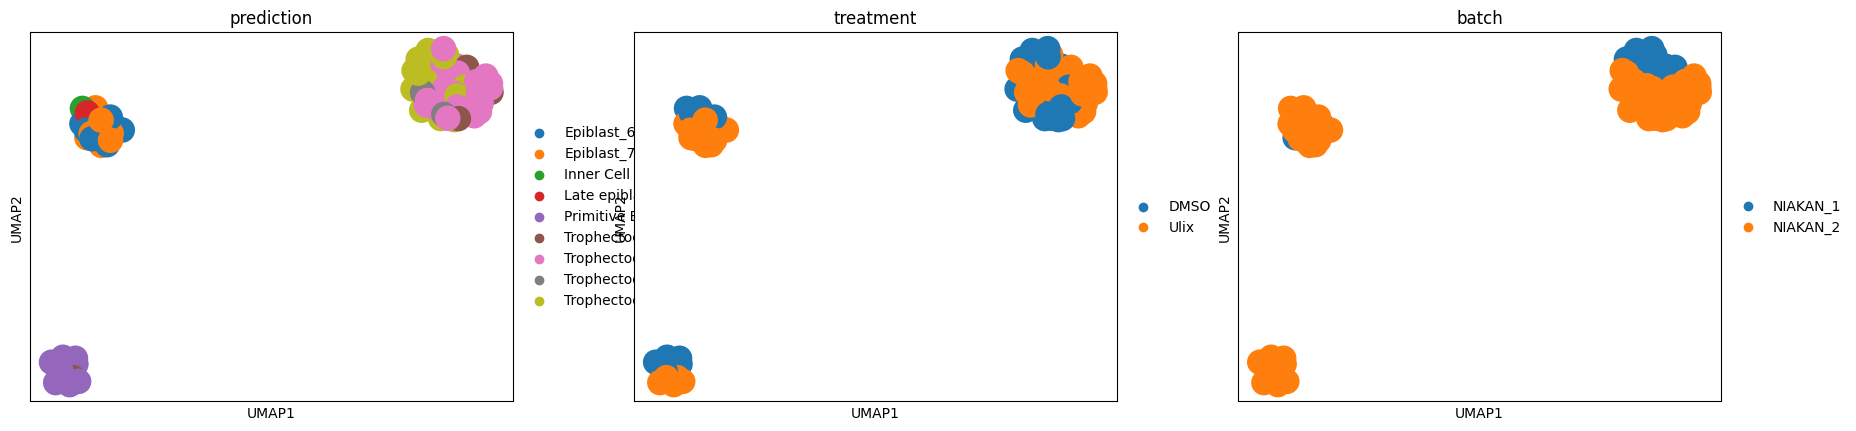

In [42]:
sc.pl.umap(adata, color=['prediction', 'treatment','batch'], size = 20)

In [43]:
sc.metrics.confusion_matrix('treatment', 'prediction', normalize=False, data=adata.obs)

prediction,Epiblast_6.0,Epiblast_7.0,Inner Cell Mass,Late epiblast,Primitive Endoderm,Trophectoderm_6.0,Trophectoderm_7.0,Trophectoderm_8.0,Trophectoderm_9.0
treatment,,,,,,,,,
DMSO,1,3,1,1,7,3,9,1,10
Ulix,7,9,1,0,4,5,19,1,7


In [46]:
sc.metrics.confusion_matrix('batch', 'prediction', normalize=False, data=adata.obs)

prediction,Epiblast_6.0,Epiblast_7.0,Inner Cell Mass,Late epiblast,Primitive Endoderm,Trophectoderm_6.0,Trophectoderm_7.0,Trophectoderm_8.0,Trophectoderm_9.0
batch,,,,,,,,,
NIAKAN_1,2,3,0,0,0,3,9,0,8
NIAKAN_2,6,9,2,1,11,5,19,2,9


In [44]:
adata.obs['treatment'].value_counts()

Ulix    53
DMSO    36
Name: treatment, dtype: int64

In [45]:
adata.write("../results/niakan_08.withPredictions.adata.h5ad")